# COVID19 Tweets

## We are using a twitter data set that has been collected using Twitter API with a high-frequency hashtag (#covid19). We are using a sample set of ~180k tweets for the period of July 24 to August 30. More details on the data and python script can be accessed on [Kaggle](http://www.kaggle.com/gpreda/covid19-tweets).

## Using this data, we have tried to answer 10 business questions:
>#### 1. Which countries are most people tweeting from? <br> 2. What sources have people used more commonly to tweet <br> 3. What are the common hash tags used in these tweets? <br> 4. Is there any trend in the tweets on a daily basis? <br> 5. Who are the most followed people/ accounts amongst these tweets? <br> 6. What are the most common words in the tweets? <br> 7. What is the sentiment in the tweets? <br> 8. Which accounts mostly have a positive and negative tweets? <br> 9. Does most favoritized tweets have any sentiment pattern/ trend? <br> 10. Which entities (people, locations, organizations) have been talked about the most.

## Import Libraries and Data Load

In [ ]:
#! pip install branca==0.4.1 #0.3.1
#! pip install wordcloud

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
import string
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import branca.colormap as cm
from mpl_toolkits.basemap import Basemap
import requests
import folium
from folium import plugins
from folium.plugins import HeatMap
import branca.colormap
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from tqdm import tqdm, notebook
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df = pd.read_csv(os.path.join(dirname, filename))
df.head()

## Exploration Data Analysis (EDA)

In [ ]:
df.info()

In [ ]:
df.date.min(), df.date.max()

In [ ]:
# There are no retweets in the data
df['is_retweet'].value_counts()

In [ ]:
# ~15% tweets have been tweeted by verified users
df['user_verified'].value_counts(normalize=True)

In [ ]:
df.describe()

In [ ]:
sns.heatmap(df.corr())

## Detailed Analysis

In [ ]:
# Make a copy of dataframe before making any changes
tweets = df.copy()

In [ ]:
# Convert date columns to datetime data type from object
tweets['date'] = pd.to_datetime(tweets['date'])
tweets['user_created'] = pd.to_datetime(tweets['user_created'])
tweets['date_ext'] = tweets['date'].dt.date

In [ ]:
# Take care of nulls in location and description
tweets.user_location.fillna('Unknown', inplace=True)
tweets.user_description.fillna('Unknown', inplace=True)
tweets.source.fillna('Unknown', inplace=True)
tweets.hashtags.fillna('None', inplace=True)

In [ ]:
# Verify
tweets.info()

In [ ]:
# Attempt tp clean the location column. There are many other business rules that can be applied to 
# improve the accuracy of different cases. We can also use regular expressions

# If both country and city is mentioned

tweets["country"] = tweets.user_location.apply(lambda x: x.split(",")[-1].strip() \
                                            if ("," in x) else x)
tweets["city"] = tweets.user_location.apply(lambda x: x.split(",")[0].strip() \
                                            if ("," in x) else x)

# Replacing 2 digit US states with USA except UK
tweets["country"] = tweets.country.apply(lambda x: 'USA' if len(x.lower().strip())<3 and x!='uk' else x)

# Standarizing case senstive cases
tweets["country"] = tweets.country.apply(lambda x: 'USA' if x.lower().strip() in \
                                      ("united states, usa, us") else x)
tweets["country"] = tweets.country.apply(lambda x: 'India' if x.lower().strip() in \
                                      ("india") else x)

# Removing countries from city column
tweets["city"] = tweets.city.apply(lambda x: 'Unknown' if x.lower() in \
                                   ['india', 'united states', 'united kingdom', 'uk', 'usa', 'us'] \
                                   else x)

## Plot heatmap to see the geographical distribution based on number of tweets

In [ ]:
# Taking top 100 countries and cities excluding the unknown at index 0
top100_count = tweets.country.value_counts(sort=True, ascending=False)[1:101]
top100_count = pd.DataFrame(top100_count)

top100_city= tweets.city.value_counts(sort=True, ascending=False)[1:101]
top100_city = pd.DataFrame(top100_city)

In [ ]:
def get_coordinates(input_type, name, output_as='center'):
    """
    Function to get coordinates of country/ city

    Attributes
    ----------
    input_type : str
        Pass 'country' or 'city' to generate the respective URL
    name : str
        Name of the country or city we need the coordinates for
    output_as : str
        Pass 'center' or 'boundingbox' depending upon what coordinates type to fetch
    
    Methods
    -------
        Returns the coordinates of the country or city
    """
    # create url
    url = '{0}{1}{2}'.format('http://nominatim.openstreetmap.org/search?'+input_type+'='\
                             ,name,'&format=json&polygon=0')
    response = requests.get(url)
    try:
        response = response.json()[0]
        # parse response to list
        if output_as == 'center':
            lst = [response.get(key) for key in ['lat','lon']]
            output = [float(i) for i in lst]
        if output_as == 'boundingbox':
            lst = response[output_as]
            output = [float(i) for i in lst]
        return output
    
    except (IndexError, ValueError):
        # this will log the whole traceback
        return [0,0]

In [ ]:
# Get the latitudes and longitudes for the top 100 countries and cities
lat_long_count = [get_coordinates("country",coun) for coun in top100_count.index]
lat_long_city = [get_coordinates("city",city) for city in top100_city.index]

In [ ]:
# Call the get_coodinates() and drop the duplicates from dataframe
def top100_df(input_type,df,lat_long):
    # merge lat and long with original dataframe
    for i, pair in zip(df.index, lat_long):
        df.loc[i,'lat'] = pair[0]
        df.loc[i,'long'] = pair[1] 
    # reset the index as country names
    df.reset_index(level=0, inplace=True)
    if input_type=="country":
        df.rename(columns={"country":"# of tweets","index":"country"}, inplace=True)
    elif input_type=="city":
        df.rename(columns={"city":"# of tweets","index":"city"}, inplace=True)
    # drop the countries/ cities with unidetified and duplicated latitudes and longitudes
    df.drop_duplicates(subset=['lat','long'],inplace=True)
    return df

In [ ]:
# Call the top100_df() to finalize the country and city dataframes 
top100_count = top100_df("country",top100_count,lat_long_count)
top100_city = top100_df("city",top100_city,lat_long_city)

In [ ]:
# Tweets trend by Country and City
fig, (ax1, ax2) = plt.subplots(2, 1, squeeze=True, figsize=(16,12))

ax1.fill_between(top100_count.country, top100_count['# of tweets'], color="skyblue", alpha=0.4)
ax1.plot(top100_count.country, top100_count['# of tweets'], color="Slateblue", alpha=0.8)
ax1.set_title("\n\n Tweets by Country", fontsize=16)

ax2.fill_between(top100_city.city, top100_city['# of tweets'],  color="aqua", alpha=0.4)
ax2.plot(top100_city.city, top100_city['# of tweets'], color="darkblue", alpha=0.8)
ax2.set_title("\n\n Tweets by City", fontsize=16)

for ax in fig.axes:
    ax.tick_params(labelrotation=90)
    
fig.tight_layout()
fig.show()

#### We see that US, India, and England are the top 3 countries with the hightest tweets with USA having significantly higher tweets (~20%). The curve is almost flattened beyond the top 3 countries with ~2k (or less) tweets per country. <br> The top 5 cities with highest tweets are London, New Delhi, New York, Mumbai, Washington with each having 2k-3k tweets.

In [ ]:
# Create a heatmap using folium
def color(magnitude):
    if magnitude>=2000:
        col='red'
    elif (magnitude>=500 and magnitude<2000):
        col='beige'
    elif magnitude<500:
        col='green'
    return col

def generateBaseMap(input_type,df,default_location=[40.693943, -73.985880], default_zoom_start=2):
    """
    Function to generate the heatmap

    Attributes
    ----------
    input_type : str
        Pass 'country' or 'city' to generate the respective heatmap
    df : str
        Name of the dataframe having the country/city coordinates and other details
    default_location : int
        Pass the default location for the displayed heatmap
    default_zoom_start: int
        Pass the default zoom for the displayed heatmap
    
    Methods
    -------
        Returns the base_map
    """
        
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    marker_cluster = plugins.MarkerCluster().add_to(base_map)
    
    HeatMap(data=df[['lat','long']].values.tolist(),radius=20,max_zoom=13).add_to(base_map)
    for lat,lan,tweet,name in zip(df['lat'],df['long'],df['# of tweets'],df.iloc[:,0]): 
        # Marker() takes location coordinates as a list as an argument 
        folium.Marker(location=[lat,lan],popup = [name,tweet], 
                      icon= folium.Icon(color=color(tweet), 
                      icon_color='white', icon='twitter', prefix='fa')).add_to(marker_cluster)
        
    #specify the min and max values of your data
    min, max = df['# of tweets'].min(), df['# of tweets'].max()
    colormap = cm.LinearColormap(colors=['green','beige','red'], vmin=min,vmax=max)
   
    colormap.caption = input_type.title() +' distribution of COVID-19 tweets'
    colormap.add_to(base_map)
    return base_map

In [ ]:
generateBaseMap('country',top100_count)

In [ ]:
generateBaseMap('city',top100_city)

#### In the heatmaps above, we can see a high concentration in regions with higher tweets. As we zoom in the heatmap, we see the number of tweets for each country and city. The color (red,yellow,green) of icon tells the intensity of tweets from high to low and as we hover over each icon, we see the name of country/ city and it's number of tweets.

In [ ]:
# Compare the tweet source
top10_source = tweets.source.value_counts().nlargest(10)
fig = plt.figure(figsize = (20,5))
plt.bar(top10_source.index, top10_source.values, color="lightblue", edgecolor="darkblue")
plt.ylabel('# of Tweets')
plt.title("Tweets by source", fontsize=16);

#### 32% of people have tweeted using the Web App, closely followed by Android users with 22%, and iPhone users with 20%.

In [ ]:
# Most trended hashtags
top10_hashtags = tweets.hashtags.str.lower().value_counts().nlargest(10)
# initiate the figure with it's size
fig = plt.figure(figsize = (10,5))
plt.barh(top10_hashtags.index, top10_hashtags.values)
plt.xlabel('# of Tweets')
plt.title("Tweets by hashtags", fontsize=16);

#### As expected, ~70% of the tweets mention either covid19 or coronavirus as the hastag.

In [ ]:
# Daily tweet trend
daily_tweets = tweets.groupby(['date_ext'])['text'].count()

fig = plt.figure(figsize = (15,5))
plt.plot(daily_tweets.index,daily_tweets.values)
plt.title('Daily Tweets\' Trend', fontsize=16)
plt.xlabel('Dates')
plt.ylabel('# of Tweets')
plt.show()

#### We see quite a spike in number of tweets in the last week of July. This could possibly be because of the highest number of corona cases during that time as reported by Worldometers. July 24, had the highest daily corona cases till date with ~290k globally and ~80k in the US. This could probably explain the high volume of tweets in that week and especially on July 25th. 
[Source: Worldometers daily cases (US)](http://www.worldometers.info/coronavirus/country/us/)
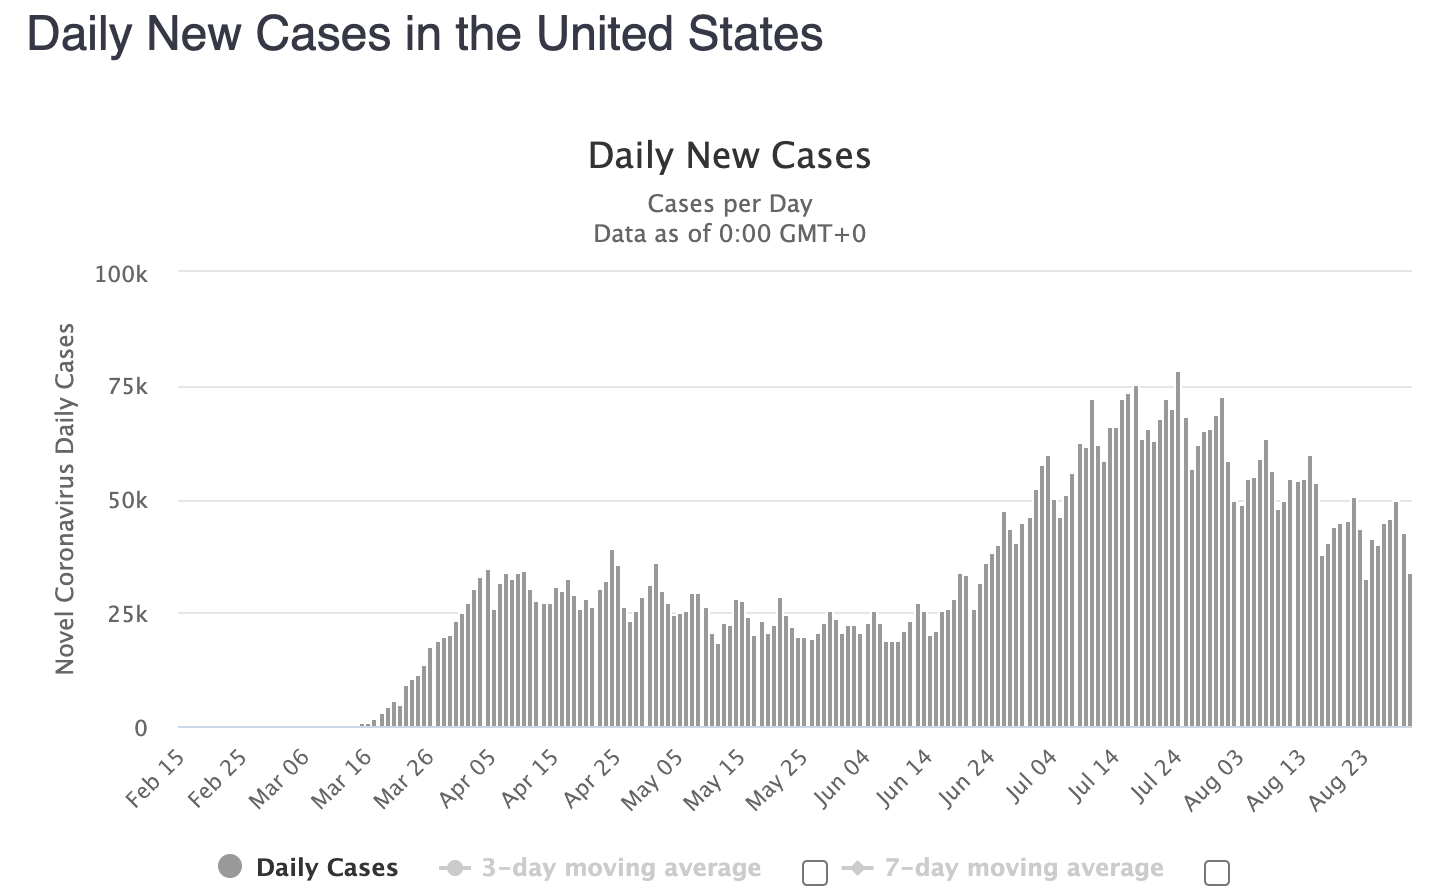


In [ ]:
# Top 10 twitter accounts being followed
top10users = tweets.groupby(by=["user_name"])['user_followers'].max().sort_values(ascending=False)[:10]
top10users.to_frame().style.bar()

#### CNN, and National Geographic are the top 2 twitter accounts to be followed the most with CNN having over 50m followers, and National Geographic having ~25m followers. Next in line are CGTN, NDTV, and Times of India with each having slightly over 13m followers.

## Check sentiment of tweets
### Preprocessing text

In [ ]:
# Convert everything other than a-z, A-Z, 0-9 to space and remove the link from tweets
tweets['clean_tweet'] = tweets['text'].apply(lambda x: re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", x))

### Create WordCloud

In [ ]:
def createWordCloud(input_type, text):
    """
    Function to generate the wordcloud

    Attributes
    ----------
    input_type : str
        Pass 'words' or 'entities' to update the chart title based on the text passed
    text : str
        Name of the string text to make the wordcloud
    
    Methods
    -------
        Returns the wordcloud
    """
    wordcloud = WordCloud(width = 1000, height = 600, 
                      #colormap = 'Paired',
                      background_color ='white',
                      collocations = False,
                      stopwords=stop_words
                     ).generate(text)

    plt.figure(figsize = (12, 12), facecolor = None)
    plt.title("Most common "+ input_type +" in the tweets \n", fontsize=20, color='Black')
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

In [ ]:
# Create a wordcloud for most popular words in tweets
text = '' 
stop_words = set(stopwords.words("english"))
for row in tweets['clean_tweet']:
    # typecaste each row to string and split it to get tokens
    tokens = str(row).split()
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
    text += " ".join(tokens)+" "

createWordCloud("words",text)

#### As expected, the most common words that pop up in these tweets are all corona related viz. covid19, coronavirus, pandemic, vaccine, death, mask, etc.

### Calculate Sentiments

In [ ]:
# We are using Compound score to detect the tweet sentiment which is a metric that calculates the sum of
# all the lexicon ratings which have been normalized between 
# -1(most extreme negative) and +1 (most extreme positive)
# positive: (compound score >= 0.05), negative : (compound score <= -0.05), neutral otherwise
sid = SentimentIntensityAnalyzer()
for index, row in tqdm(tweets.iterrows()): #tqdm 
    ss = sid.polarity_scores(row['clean_tweet'])
    if ss['compound'] >= 0.05 : 
        tweets.at[index,'sentiment'] = "Positive"
    elif ss['compound'] <= - 0.05 : 
        tweets.at[index,'sentiment'] = "Negative"
    else : 
        tweets.at[index,'sentiment'] = "Neutral"

In [ ]:
# Show distribution of tweet sentiments
sentiment_dist = tweets.sentiment.value_counts()

plt.pie(sentiment_dist, labels=sentiment_dist.index, explode= (0.1,0,0),
        colors=['yellowgreen', 'gold', 'lightcoral'],
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Tweets\' Sentiment Distribution \n", fontsize=16, color='Black')
plt.axis('equal')
plt.tight_layout()
plt.show()

####  A total of ~70k tweets have a positive sentiment making the largest pie in the chart with ~40% tweets.

In [ ]:
# Function to filter top 10 tweets by sentiment
def top10AccountsBySentiment(sentiment):
    df = tweets.query("sentiment==@sentiment")
    top10 = df.groupby(by=["user_name"])['sentiment'].count().sort_values(ascending=False)[:10]
    return(top10)

In [ ]:
# Top 10 tweets by each sentiment
top10_pos = top10AccountsBySentiment("Positive")
top10_neg = top10AccountsBySentiment("Negative")
top10_neu = top10AccountsBySentiment("Neutral")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, squeeze=True, figsize=(16,8))
fig.suptitle('Top 10 Twitter Accounts \n', fontsize=20)

ax1.barh(top10_pos.index, top10_pos.values, color='yellowgreen')
ax1.set_title("\n\n Positive Tweets", fontsize=16)

ax2.barh(top10_neg.index, top10_neg.values, color='lightcoral')
ax2.set_title("\n\n Negative Tweets", fontsize=16)

ax3.barh(top10_neu.index, top10_neu.values, color='gold')
ax3.set_title("\n\n Neutral Tweets", fontsize=16);

fig.tight_layout()
fig.show()

#### 'GlobalPandemic.NET' has the hightest number of positive tweets while 'Open Letters' leads the list for having maximum negative tweets and 'Coronavirus Updates' for neutral tweets.

In [ ]:
# Sentiment of top 10 favoritized tweets
top10tweets = tweets.nlargest(10, ['user_favourites'])[['user_name','clean_tweet','user_verified','sentiment']]
top10tweets.groupby(by=['user_name','sentiment'])['clean_tweet'].count().to_frame().style.bar()

In [ ]:
top10tweets

#### Amongst the top favoritized tweets, three (non-verified) accounts pop-up Patty, Paolo, and Chelsea. The negative tweets here showcase concerns about the rising COVID-19 cases and US' inability to contain it. On the other hand, there are some positive tweets talking about how the situation might improve once a vaccine is made. The other neutral tone tweets are mostly an update on the number of covid19 cases.

### Check Most Frequent Entities

In [ ]:
# Create dictionary of entities and their frequency in the tweets then create a wordcloud
tt = TweetTokenizer()
entities={}

for sent in tqdm(tweets.clean_tweet):
    for chunk in ne_chunk(pos_tag(tt.tokenize(sent)), binary=True):
        if hasattr(chunk, 'label'):
            if chunk[0][0] in entities.keys():
                entities[chunk[0][0]] = entities[chunk[0][0]]+1
            else:
                entities[chunk[0][0]]=1
                
#sorted by value, return a list of tuples   
top50_entities = sorted(entities.items(), key=lambda x: x[1], reverse=True)[:50]
entities_text = " ".join([(k + " ")*v for k,v in dict(top50_entities).items()])

In [ ]:
# Plot the most frequent entities to show the frequency trend line
createWordCloud("entities",entities_text)

x, y = zip(*top50_entities) # unpack a list of pairs into two tuples
plt.figure(figsize=[15,8])
plt.plot(x, y)
plt.xticks(rotation=90)
plt.title("Most frequent entities mentioned in tweets", fontsize=16)
plt.show();

#### In terms of entities that have been most talked about, as expected, COVID tops the list again. Interestingly, other entities to notice are Donald Trump (3rd and 7th on the list), Joe Biden, Boris Johnson, Congress, WHO, CDC. <br> We also see a few countries like India, US, China, Russia, and cities/ states like Odisha (a city in India), Florida, Texas etc. that have been quite talked about.

### Looking into tweets talking about 'Trump'

In [ ]:
# Tweets that has Trump mentioned in them
trump_tweets = tweets[tweets['clean_tweet'].str.contains("realDonaldTrump|Trump")]
trump_tweets.query("sentiment=='Negative'")['clean_tweet'].tail(10)

In [ ]:
trump_tweets.sentiment.value_counts(normalize=True)

#### Out of all the tweets that mention 'Trump', almost 50% have a negative tone. When inspected most of these tweets had people talking about the increasing corona cases. Some of the tweets talk about country's inefficiency in promoting awareness about coronavirus, having faulty ventilators, lack of much needed preventive measure etc.

## Closing thoughts

1.  US (New York, Washinton), India (New Delhi, Mumbai), and England (London) have the hightest tweets. These are also the most populated and metropolitan cities clearly indicating that people in these cities are more active on Twitter.
2. People using twitter on mobile are 1.5x of the ones using web when combined the Android and iPhone users collectively making ~45% of tweets.
3. Looking at the tweets' trend, people have tweeted more following a spike in covid19 cases especially when cases on June 24 were the highest till date, we see a huge spike in number of tweets on June 25.
4. As expected, most of the news channels like CNN, National Geographic, CGTN, NDTV, and Times of India are the top 5 twitter accounts to be followed with CNN having over 50m followers, and National Geographic having ~25m followers.
5. While doing text analysis, we captured the words like covid19, coronavirus, pandemic, vaccine, death, mask, etc. which were mostly talked about.
6. Overall there were more positive tweets (~40%) than negative or neutral, indicating people still have great hopes for the world to become normal soon again. When analyzing positive tweets further, we found 'GlobalPandemic.NET' leads the list for having the highest number of positive tweets while 'Open Letters' leads the negative tweet list and 'Coronavirus Updates' for neutral tweets.
7. Amongst the top 10 favorited tweets, tweeted by three (non-verified) accounts pop-up Patty, Paolo, and Chelsea:
    * The negative tweets showcased concerns about the rising COVID-19 cases and US' inability to contain it.
    * The positive tweets talked about how the situation might improve once a vaccine is made.
    * The neutral tweets were mostly an update on the number of covid19 cases.
8. Apart from the most obvious word 'COVID', the other entities to be most talked about were Donald Trump, Joe Biden, Boris Johnson, Congress, WHO, CDC. A few countries like India, US, China, Russia, and cities/ states like Odisha (a city in India), Florida, Texas etc. were very frequent mentioned as well.

### I hope you enjoyed my kernel. You can use this dataset for any text based analysis. Can't wait to see your work! Please upvote if you like my work 😃

## References
- https://stackoverflow.com/questions/44173624/how-to-apply-nltk-word-tokenize-library-on-a-pandas-dataf**rame-for-twitter-data
- https://basemaptutorial.readthedocs.io/en/latest/plotting_data.html#text
- https://zapcircle.net/geomapping-with-python/
- https://matplotlib.org/basemap/users/geography.html
- https://queirozf.com/entries/add-labels-and-text-to-matplotlib-plots-annotation-examples
- https://colab.research.google.com/drive/1HJB7UGj7YuUEJi-cKZRAr3O4Dlym2KrP#scrollTo=0H-uRYF1iIjS
- https://stackoverflow.com/questions/56876620/unsure-how-to-use-colormap-with-folium-marker-plot
- https://www.geeksforgeeks.org/generating-word-cloud-python/
- https://www.nltk.org/howto/sentiment.html
- https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
    